In [ ]:
cd musical_instrument_detection/experiments/

In [1]:
import pickle
params = pickle.load(open("finetuned_net_fold0_params.plk"))

In [2]:
import numpy as np
import theano
import theano.tensor as T
import lasagne


from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax

IMAGE_MEAN = np.array([[[ 103.939]],
                       [[ 116.779]],
                       [[ 123.68 ]]])

def build_model():
    net = dict()
    net['input'] = InputLayer((None, 3, 224, 224))
    net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1)
    net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1)
    net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1)
    net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1)
    net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1)
    net['pool3'] = PoolLayer(net['conv3_3'], 2)
    net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1)
    net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1)
    net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1)
    net['pool4'] = PoolLayer(net['conv4_3'], 2)
    net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1)
    net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1)
    net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1)
    net['pool5'] = PoolLayer(net['conv5_3'], 2)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['fc7'] = DenseLayer(net['fc6'], num_units=4096)
    net['fc8'] = DenseLayer(net['fc7'], num_units=1000, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc8'], softmax)

    return net

net = build_model()
cnn_model = DenseLayer(net['fc7'], num_units=12, nonlinearity=softmax)   # 12 classes

X_sym = T.tensor4()
y_sym = T.ivector()
prediction = lasagne.layers.get_output(cnn_model, X_sym)
loss = lasagne.objectives.categorical_crossentropy(prediction, y_sym)
loss = loss.mean()
acc = T.mean(T.eq(T.argmax(prediction, axis=1), y_sym),
                      dtype=theano.config.floatX)

lasagne.layers.set_all_param_values(cnn_model, params)
pred_fn = theano.function([X_sym], prediction)

/Users/olya/user_env/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
/Users/olya/user_env/lib/python2.7/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


In [4]:
import os
from utils import load, visualization


def get_images(dir_name):
    for image_name in os.listdir(dir_name):
        yield os.path.abspath(os.path.join(dir_name, image_name)), 0

            
def load_data(image_mean, image_dir):
    # Load and preprocess the entire dataset into numpy arrays
    X = []
    y = []

    for image_name, class_label in get_images(image_dir):
        _, im = load.prep_image(image_name, image_mean)
        X.append(im)
        y.append(class_label)

    X = np.concatenate(X)
    y = np.array(y).astype('int32')
    return X, y


X, y = load_data(IMAGE_MEAN, "./video/frames")

In [5]:
BATCH_SIZE = 64

# generator splitting an iterable into chunks of maximum length N
def batches(iterable, N):
    chunk = []
    for item in iterable:
        chunk.append(item)
        if len(chunk) == N:
            yield chunk
            chunk = []
    if chunk:
        yield chunk

def predict_batch(X_data, pred_fn):
    y_pred = []
    for chunk in batches(X_data, BATCH_SIZE):
        y_pred.extend(pred_fn(chunk))
    return y_pred

predict_y = predict_batch(X, pred_fn)

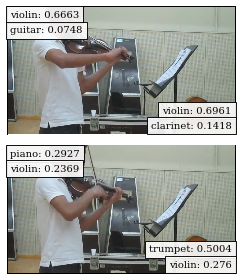

In [179]:
predict = np.array(predict_y)

import heapq
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from matplotlib import rc
rc('text', usetex=False)
rc('font', family='serif', size=10)

res_audio = [['trumpet: 0.3618', 'voice: 0.2343'],
             ['clarinet: 0.5827', 'saxophone: 0.1552'],
             ['trumpet: 0.4956', 'violin: 0.3266'],
             ['trumpet: 0.528', 'flute: 0.2637'],
             ['trumpet: 0.2788', 'clarinet: 0.273'],
             ['trumpet: 0.5107', 'violin: 0.3415'],
             ['trumpet: 0.4935', 'clarinet: 0.2608'],
             ['violin: 0.6961', 'clarinet: 0.1418'],
             ['trumpet: 0.5004', 'violin: 0.276'],
             ['violin: 0.5376', 'trumpet: 0.2859'],
             ['trumpet: 0.5966', 'clarinet: 0.1719'],
             ['piano: 0.4228', 'violin: 0.2657']]

plt.clf()

x_m = 1
y_m = 2
w = 4
h = 3

fig = plt.figure(figsize=(y_m*h, x_m*w))
start=7

for i in range(x_m*y_m):
    image = plt.imread("./video/frames/frame{index}.jpg".format(index=i+1+start))
    ax = fig.add_subplot(y_m, x_m, i+1)
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])
    im_pred = heapq.nlargest(2, range(len(predict[i+start])), predict[i+start].__getitem__)
    image_text1 = labels[im_pred[0]] + ": " + str(round(predict[i+start][im_pred[0]], 4))
    image_text2 = labels[im_pred[1]] + ": " + str(round(predict[i+start][im_pred[1]], 4))
    audio_text1 = res_audio[i+start][0]
    audio_text2 = res_audio[i+start][1]
    
    ax.text(0.0125, 0.9, image_text1, color='black',
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.9))
    ax.text(0.0125, 0.78, image_text2, color='black',
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.9))
    
    ax.text(0.9875, 0.15, audio_text1, color='black', 
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.9))
    ax.text(0.9875, 0.03, audio_text2, color='black',
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.9))
    fig.add_subplot(ax)

all_axes = fig.get_axes()

for index, ax in enumerate(all_axes):
    for sp in ax.spines.values():
        sp.set_visible(False)
    if ax.is_first_row():
        ax.spines['top'].set_visible(True)
    if ax.is_last_row():
        ax.spines['bottom'].set_visible(True)
    if ax.is_first_col():
        ax.spines['left'].set_visible(True)
    if ax.is_last_col():
        ax.spines['right'].set_visible(True)

plt.tight_layout()
plt.savefig("cs_violin.pdf", bbox_inches='tight')

In [8]:
instruments_mapping = {"accordion": "n02672831",
                       "banjo": "n02787622",
                       "cello": "n02992211",
                       "trumpet": "n03110669",
                       "drum": "n03249569",
                       "flute": "n03372029",
                       "guitar": "n03467517",
                       "oboe": "n03838899",
                       "piano": "n03928116",
                       "saxophone": "n04141076",
                       "trombone": "n04487394",
                       "violin": "n04536866"}
image_seq = ['n04536866', 'n02992211', 'n04487394', 'n03928116', 
             'n02787622', 'n02672831', 'n03110669', 'n03838899', 
             'n03372029', 'n04141076', 'n03467517', 'n03249569']
labels = ["violin", "cello", "trombone", "piano", 
          "banjo", "accordion", "trumpet", "oboe", 
          "flute", "saxophone", "guitar", "drum"]

In [10]:
# ffmpeg -i ../../videodb/jjj/jjj0Ju3mDFk.mp4 -vf fps=0.15 frame%d.jpg
X2, y2 = load_data(IMAGE_MEAN, "./video/frames2")
predict_y2 = predict_batch(X2, pred_fn)
predict2 = np.array(predict_y2)

In [43]:
"""
for elem in predict2:
    print max(elem), np.where(elem == max(elem))
    
for elem in predict:
    print max(elem), np.where(elem == max(elem))
"""
for elem in predict3:
    print max(elem), np.where(elem == max(elem))

0.356105736723 (array([1]),)
0.790208070957 (array([1]),)
0.552101744105 (array([1]),)
0.678792795212 (array([1]),)
0.570922792658 (array([1]),)
0.473137678948 (array([1]),)
0.631271891225 (array([1]),)
0.822093171532 (array([1]),)
0.575274947293 (array([1]),)


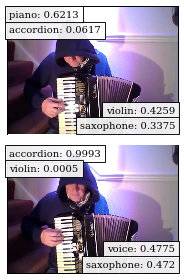

In [167]:
import heapq
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from matplotlib import rc
rc('text', usetex=False)
rc('font', family='serif', size=10)

res_audio = [['saxophone: 0.7231', 'voice: 0.1196'],
             ['saxophone: 0.7515', 'violin: 0.1403'],
             ['violin: 0.4259', 'saxophone: 0.3375'],
             ['voice: 0.4775', 'saxophone: 0.472'],
             ['piano: 0.3436', 'violin: 0.2643'],
             ['violin: 0.2562', 'cello: 0.2257']]

plt.clf()

x_m = 1
y_m = 2
w = 4
h = 3

fig = plt.figure(figsize=(y_m*h, x_m*w))
start=2

for i in range(x_m*y_m):
    image = plt.imread("./video/frames2//frame{index}.jpg".format(index=i+1+start))
    ax = fig.add_subplot(y_m, x_m, i+1)
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])
    im_pred = heapq.nlargest(2, range(len(predict2[i+start])), predict2[i+start].__getitem__)
    image_text1 = labels[im_pred[0]] + ": " + str(round(predict2[i+start][im_pred[0]], 4))
    image_text2 = labels[im_pred[1]] + ": " + str(round(predict2[i+start][im_pred[1]], 4))
    audio_text1 = res_audio[i+start][0]
    audio_text2 = res_audio[i+start][1]
    
    ax.text(0.0125, 0.9, image_text1, color='black',
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.9))
    ax.text(0.0125, 0.78, image_text2, color='black',
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.9))
    
    ax.text(0.9875, 0.15, audio_text1, color='black', 
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.9))
    ax.text(0.9875, 0.03, audio_text2, color='black',
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.9))
    fig.add_subplot(ax)

all_axes = fig.get_axes()

for index, ax in enumerate(all_axes):
    for sp in ax.spines.values():
        sp.set_visible(False)
    if ax.is_first_row():
        ax.spines['top'].set_visible(True)
    if ax.is_last_row():
        ax.spines['bottom'].set_visible(True)
    if ax.is_first_col():
        ax.spines['left'].set_visible(True)
    if ax.is_last_col():
        ax.spines['right'].set_visible(True)

plt.tight_layout()
plt.savefig("cs_accordion.pdf", bbox_inches='tight')

In [13]:
# ffmpeg -i ../../videodb/eer/eeri7gE3ZJ0.mp4 -vf fps=0.15 frame%d.jpg
X3, y3 = load_data(IMAGE_MEAN, "./video/frames3")
predict_y3 = predict_batch(X3, pred_fn)
predict3 = np.array(predict_y3)

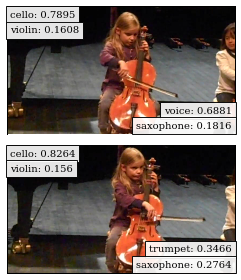

In [161]:
import heapq
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from matplotlib import rc
rc('text', usetex=False)
rc('font', family='serif', size=10)

res_audio = [['voice: 0.6881', 'saxophone: 0.1816'],
             ['trumpet: 0.3466', 'saxophone: 0.2764'],
             ['saxophone: 0.2104', 'clarinet: 0.1829'],
             ['trumpet: 0.5738', 'guitar (acoustic): 0.1451'],
             ['voice: 0.4972', 'guitar (electric): 0.1439']]
plt.clf()

x_m = 1
y_m = 2
w = 4
h = 3

fig = plt.figure(figsize=(y_m*h, x_m*w))
start=5

for i in range(x_m*y_m):
    image = plt.imread("./video/frames3/frame{index}.jpg".format(index=i+1+start))
    ax = fig.add_subplot(y_m, x_m, i+1)
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])
    im_pred = heapq.nlargest(2, range(len(predict3[i+start])), predict3[i+start].__getitem__)
    image_text1 = labels[im_pred[0]] + ": " + str(round(predict3[i+start][im_pred[0]], 4))
    image_text2 = labels[im_pred[1]] + ": " + str(round(predict3[i+start][im_pred[1]], 4))
    audio_text1 = res_audio[i][0]
    audio_text2 = res_audio[i][1]
    
    ax.text(0.0125, 0.9, image_text1, color='black',
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.9))
    ax.text(0.0125, 0.78, image_text2, color='black',
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.9))
    
    ax.text(0.9875, 0.15, audio_text1, color='black', 
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.9))
    ax.text(0.9875, 0.03, audio_text2, color='black',
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.9))
    fig.add_subplot(ax)

all_axes = fig.get_axes()

for index, ax in enumerate(all_axes):
    for sp in ax.spines.values():
        sp.set_visible(False)
    if ax.is_first_row():
        ax.spines['top'].set_visible(True)
    if ax.is_last_row():
        ax.spines['bottom'].set_visible(True)
    if ax.is_first_col():
        ax.spines['left'].set_visible(True)
    if ax.is_last_col():
        ax.spines['right'].set_visible(True)

plt.tight_layout()
plt.savefig("cs_cello.pdf", bbox_inches='tight')

In [18]:
# ffmpeg -i ../../videodb/mMl/mMl_P7zVrQw.mp4 -vf fps=0.15 frame%d.jpg
X4, y4 = load_data(IMAGE_MEAN, "./video/mMl_videoframes")
predict_y4 = predict_batch(X4, pred_fn)
predict4 = np.array(predict_y4)

In [55]:
for elem in predict4:
    print ", ".join([str(val) + " " + labels[num] for num, val in enumerate(elem)])

0.00716928242214 violin, 0.00342521034839 cello, 0.000799343183805 trombone, 0.000173686880089 piano, 0.0276921243722 banjo, 0.00848614363254 accordion, 0.00467611316467 trumpet, 0.0018664918943 oboe, 0.0390046373349 flute, 0.00476091633831 saxophone, 0.901229266523 guitar, 0.000716783905241 drum
0.00788377854207 violin, 0.00183376660328 cello, 0.000444993105685 trombone, 0.000180296794829 piano, 0.0205976148501 banjo, 0.00638894032482 accordion, 0.00291112907033 trumpet, 0.0015476716428 oboe, 0.0399289939259 flute, 0.00215715682478 saxophone, 0.914998696877 guitar, 0.00112696143824 drum
0.0320972212837 violin, 0.00534665540786 cello, 0.00433796654457 trombone, 0.000373227657214 piano, 0.0243782936908 banjo, 0.0200287665145 accordion, 0.0146459632684 trumpet, 0.0117354692671 oboe, 0.0876141185803 flute, 0.00671553214136 saxophone, 0.789570147711 guitar, 0.00315663793359 drum
0.0562682671798 violin, 0.00770579431757 cello, 0.00744053157954 trombone, 0.000254020796964 piano, 0.0245750004

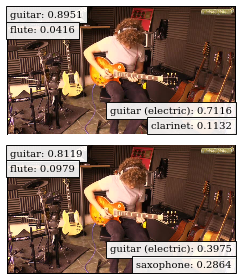

In [160]:
import heapq
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from matplotlib import rc
rc('text', usetex=False)
rc('font', family='serif', size=10)

res_audio = [['saxophone: 0.7247', 'violin: 0.1329'],
             ['guitar (electric): 0.7116', 'clarinet: 0.1132'],
             ['guitar (electric): 0.3975', 'saxophone: 0.2864'],
             ['guitar (electric): 0.4515', 'clarinet: 0.2286'],
             ['guitar (electric): 0.3991', 'saxophone: 0.3414'],
             ['saxophone: 0.785', 'guitar (electric): 0.1498'],
             ['saxophone: 0.5568', 'guitar (electric): 0.2653'],
             ['guitar (electric): 0.4009', 'saxophone: 0.3942'],
             ['saxophone: 0.4448', 'guitar (electric): 0.3435'],
             ['guitar (electric): 0.5357', 'saxophone: 0.1745'],
             ['saxophone: 0.429', 'voice: 0.3069'],
             ['organ: 0.4908', 'violin: 0.2341']]

plt.clf()

x_m = 1
y_m = 2
w = 4
h = 3

fig = plt.figure(figsize=(y_m*h, x_m*w))
start=1

for i in range(x_m*y_m):
    image = plt.imread("./video/mMl_videoframes/frame{index}.jpg".format(index=i+1+start))
    ax = fig.add_subplot(y_m, x_m, i+1)
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])
    im_pred = heapq.nlargest(2, range(len(predict4[i+start])), predict4[i+start].__getitem__)
    image_text1 = labels[im_pred[0]] + ": " + str(round(predict4[i+start][im_pred[0]], 4))
    image_text2 = labels[im_pred[1]] + ": " + str(round(predict4[i+start][im_pred[1]], 4))
    audio_text1 = res_audio[i+start][0]
    audio_text2 = res_audio[i+start][1]
    
    ax.text(0.0125, 0.9, image_text1, color='black',
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.9))
    ax.text(0.0125, 0.78, image_text2, color='black',
            verticalalignment='bottom', horizontalalignment='left',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.9))
    
    ax.text(0.9875, 0.15, audio_text1, color='black', 
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.9))
    ax.text(0.9875, 0.03, audio_text2, color='black',
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.9))
    fig.add_subplot(ax)

all_axes = fig.get_axes()

for index, ax in enumerate(all_axes):
    for sp in ax.spines.values():
        sp.set_visible(False)
    if ax.is_first_row():
        ax.spines['top'].set_visible(True)
    if ax.is_last_row():
        ax.spines['bottom'].set_visible(True)
    if ax.is_first_col():
        ax.spines['left'].set_visible(True)
    if ax.is_last_col():
        ax.spines['right'].set_visible(True)

plt.tight_layout()
plt.savefig("cs_guitar.pdf", bbox_inches='tight')